# Taller NUMBA. CUDA #2

La idea de este taller es que repase los conceptos intermedios del uso de CUDA por medio de la interfaz ofrecida por NUMBA.  implementara una función de preprocesamiento(1) y optimizara el producto de dos matrices(2).

In [ ]:
!pip install --upgrade numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1


In [ ]:
import numpy as np
from skimage import data
import tensorflow as tf
import matplotlib.pyplot as plt

import numba
from numba import cuda
import math


print(np.__version__)
print(numba.__version__)

1.25.2
0.59.1


In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-5d2d8ef3-41f6-a03c-f32c-865c28fcd657
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## 1.1) Cargue el conjunto de datos de MNIST (consulte: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) y despliegue algunas imagenes

11490434/11490434 [==============================] - 0s 0us/step


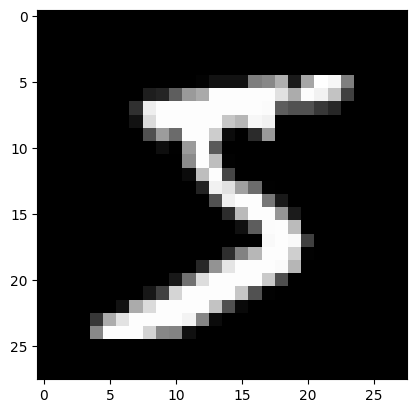

In [ ]:
data_set = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)
image = data_set[0][0][0]
plt.imshow(image, cmap='gray')
plt.show()

##1.2)  Usando arreglos compartidos realiza la operación de convolución usando una mascara de laplace (consulte: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm).

In [ ]:
@cuda.jit
def laplace(img, mask, out):
    out = np.zeros_like(img)
    rows, cols = mask.shape
    x, y = cuda.grid(2)
    if x < rows and y < cols:
      for i in range(1,rows):
          for j in range(1,cols):
              p=img[x-i][y-j]
              out[x][y] += abs(p*mask[i][j])



In [ ]:
img = data_set[0][0][0]
mask = np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]
])
out = np.zeros_like(img)

threads_per_block = 1024  # Why not!
blocks_per_grid = 32 * 80  # Use 32 * multiple of streaming multiprocessors
laplace[blocks_per_grid, threads_per_block](img, mask, out)


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
No implementation of function Function(<function zeros_like at 0x7c20cf590550>) found for signature:
 
 >>> zeros_like(array(uint8, 2d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'ol_np_zeros_like': File: numba/np/arrayobj.py: Line 4452.
    With argument(s): '(array(uint8, 2d, C))':
   Rejected as the implementation raised a specific error:
     TypeError: Failed in cuda mode pipeline (step: fix up args)
   Signature mismatch: 1 argument types given, but function takes 2 arguments
  raised from /usr/local/lib/python3.10/dist-packages/numba/core/untyped_passes.py:125

During: resolving callee type: Function(<function zeros_like at 0x7c20cf590550>)
During: typing of call at <ipython-input-5-f7f869ec6d35> (3)


File "<ipython-input-5-f7f869ec6d35>", line 3:
def laplace(img, mask, out):
    out = np.zeros_like(img)
    ^


##2.1) Cargue el conjunto de datos de IRIS (consulte: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

##2.2) Entre una regresión logistica usando sklearn y extraiga sus parametros (consulte: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, y)
ceficientes = clf.coef_
intercepto = clf.intercept_

##2.3) Implemente una regresión logística de forma matricial usando NUMBA y los parámetros calculados (consulte: https://en.wikipedia.org/wiki/Logistic_regression)